The use of parenthesis for accessing tasks is deprecated, use brackets instead.
The use of parenthesis for accessing tasks is deprecated, use brackets instead.
 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       0.00 |         1068 | 2.19e-01 | 9.42e-01 |       6.88


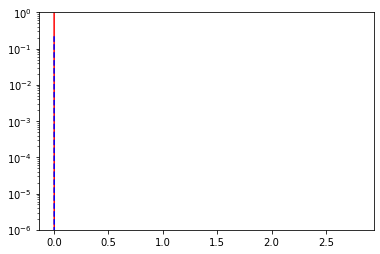

       0.20 |         1199 | 1.79e-01 | 8.39e-01 |       6.75
       0.40 |         1426 | 1.30e-01 | 7.05e-01 |       6.47
       0.60 |         2847 | 5.18e-02 | 3.52e-01 |       6.24
       0.80 |         7919 | 1.57e-02 | 1.26e-01 |       6.86
       1.00 |        46214 | 2.32e-03 | 2.16e-02 |       6.88
       1.20 |       362582 | 2.36e-04 | 2.76e-03 |       6.00


In [1]:
#!/usr/bin/env python3

import sys
sys.path.insert(0, '../../build/lib')

import numpy as np
import py_aff3ct as aff3ct
import math
import time
import matplotlib.pyplot as plt
from datetime import timedelta

K = 440*2
N = 3*K
ebn0_min = 0
ebn0_max = 3.0
ebn0_step = 0.2

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/N)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

src = aff3ct.module.source.Source_random_fast(K, 12)

# Build DVBS-RCS2 Turbo encoder.
enc_n = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS2')
enc_i = aff3ct.module.encoder.Encoder_RSC_DB(K,2*K,standard='DVB-RCS2')

# Build DVBS-RCS2 Interleaver.
itl_core = aff3ct.tools.interleaver_core.Interleaver_core_ARP_DVB_RCS2(K//2)
itl_bit  = aff3ct.module.interleaver.Interleaver_int32(itl_core)
itl_llr  = aff3ct.module.interleaver.Interleaver_float(itl_core)
enc = aff3ct.module.encoder.Encoder_turbo_DB(K,N,enc_n,enc_i,itl_bit)

# Build DVBS-RCS2 Trubo decoder.
trellis_n = enc_n.get_trellis()
trellis_i = enc_i.get_trellis()

dec_n = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS2(K,trellis_n)
dec_i = aff3ct.module.decoder.Decoder_RSC_DB_BCJR_DVB_RCS2(K,trellis_i)
dec   = aff3ct.module.decoder.Decoder_turbo_DB(K,N,8,dec_n,dec_i,itl_llr)
mdm   = aff3ct.module.modem.Modem_BPSK_fast(N)

gen = aff3ct.tools.Gaussian_noise_generator_implem.FAST
chn = aff3ct.module.channel.Channel_AWGN_LLR(N, gen)
mnt = aff3ct.module.monitor.Monitor_BFER_AR(K, 1000)

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
enc["encode       ::U_K "].bind(src["generate   ::U_K "])
mdm["modulate     ::X_N1"].bind(enc["encode     ::X_N "])
chn["add_noise    ::X_N "].bind(mdm["modulate   ::X_N2"])
mdm["demodulate   ::Y_N1"].bind(chn["add_noise  ::Y_N "])
dec["decode_siho  ::Y_N "].bind(mdm["demodulate ::Y_N2"])
mnt["check_errors ::U   "].bind(src["generate   ::U_K "])
mnt["check_errors ::V   "].bind(dec["decode_siho::V_K "])
chn["add_noise    ::CP  "].bind(                 sigma  )
mdm["demodulate   ::CP  "].bind(                 sigma  )

seq  = aff3ct.tools.sequence.Sequence(src("generate"), mnt("check_errors"), 8)

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

fig = plt.figure()
ax = fig.add_subplot(111)
line1,line2, = ax.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--') # Returns a tuple of line objects, thus the comma
plt.ylim((1e-6, 1))

print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	sigma[:] = sigma_vals[i]

	t = time.time()
	seq.exec()
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()

	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	tpt = total_fra * K * 1e-6/elapsed
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))

	mnt.reset()

	line1.set_ydata(fer)
	line2.set_ydata(ber)
	fig.canvas.draw()
	fig.canvas.flush_events()
	plt.pause(1e-6)

seq.show_stats()
plt.show()